# Deep Learning Algorithms for Movie Recommendations
## Filipe Gonçalves, 98083
## Pedro Lopes, 97827

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

### Getting the data up and running
First, we need to import libraries which we’ll be using in our movie recommendation system. Also, we’ll import the dataset by adding the path of the CSV files. Then we will have a look at the movies dataset:
- Movie dataset has:
    - movieId – once the recommendation is done, we get a list of all similar movieId and get the title for each movie from this dataset.
    - genres – which is not required for this filtering approach.
    
- Ratings dataset has:
    - userId – unique for each user.
    - movieId – using this feature, we take the title of the movie from the movies dataset.
    - rating – Ratings given by each user to all the movies using this we are going to predict the top 10 similar movies.

In [2]:
movies = pd.read_csv("./dataset/movies.csv")
ratings = pd.read_csv("./dataset/ratings.csv")

print(movies)
print(ratings)

      movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  Black Butler: Book of the Atlantic (2017)   
9738   193583               No Game No Life: Zero (2017)   
9739   193585                               Flint (2017)   
9740   193587        Bungo Stray Dogs: Dead Apple (2018)   
9741   193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4                  

### Dataset Analysis

{'Adventure': 1263, 'Animation': 611, 'Children': 664, 'Comedy': 3756, 'Fantasy': 779, 'Romance': 1596, 'Drama': 4361, 'Action': 1828, 'Crime': 1199, 'Thriller': 1894, 'Horror': 978, 'Mystery': 573, 'Sci-Fi': 980, 'War': 382, 'Musical': 334, 'Documentary': 440, 'IMAX': 158, 'Western': 167, 'Film-Noir': 87, '(no genres listed)': 34}


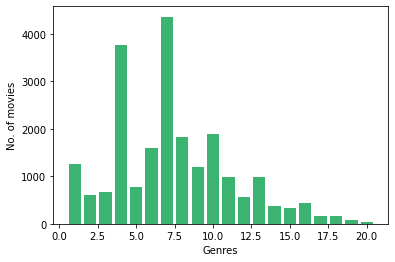

In [3]:
movies_genres = movies['genres'].apply(lambda x: str(x).split("|"))
genres_count = {}

for movie in range(len(movies['movieId'])):
    for genre in movies_genres[movie]:
        if genre in genres_count:
            genres_count[genre] += 1
        else:
            genres_count[genre] = 1

print(genres_count)
            
plt.bar(range(1,len(genres_count.keys())+1), list(genres_count.values()),color='mediumseagreen')
plt.xlabel('Genres')
plt.ylabel('No. of movies')
plt.show()

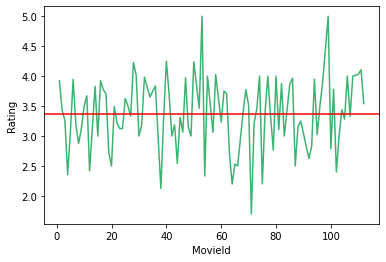

3.360345039219456


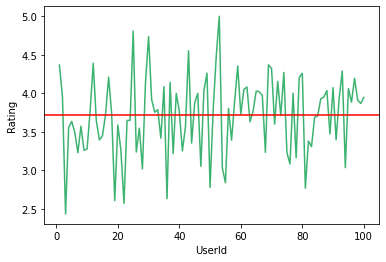

3.7169858624376184


In [4]:
average_rating_movie = ratings.groupby('movieId')['rating'].agg('sum')
average_rating_movie = average_rating_movie / ratings.groupby('movieId')['rating'].agg('count')

plt.plot(average_rating_movie[:100].index,average_rating_movie[:100],color='mediumseagreen')
plt.axhline(y=(average_rating_movie[:100].agg('sum') / average_rating_movie[:100].agg('count')),color='r')
plt.xlabel('MovieId')
plt.ylabel('Rating')
plt.show()
print(average_rating_movie[:100].agg('sum') / average_rating_movie[:100].agg('count'))

average_rating = ratings.groupby('userId')['rating'].agg('sum')
average_rating = average_rating / ratings.groupby('userId')['rating'].agg('count')

plt.plot(average_rating[:100].index,average_rating[:100],color='mediumseagreen')
plt.axhline(y=(average_rating[:100].agg('sum') / average_rating[:100].agg('count')),color='r')
plt.xlabel('UserId')
plt.ylabel('Rating')
plt.show()
print(average_rating[:100].agg('sum') / average_rating[:100].agg('count'))

Here, we can see that userId 1 has watched movieId 1 & 3 and rated both of them 4.0 but has not rated movieId 2 at all. This interpretation is harder to extract from this dataframe. Therefore, to make things easier to understand and work with, we are going to make a new dataframe where each column would represent each unique userId and each row represents each unique movieId.

In [5]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
# turn all NaN in 0
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


### Removing Noise from the data
In the real-world, ratings are very sparse and data points are mostly collected from very popular movies and highly engaged users. We wouldn’t want movies that were rated by a small number of users because it’s not credible enough. Similarly, users who have rated only a handful of movies should also not be taken into account.

So with all that taken into account and some trial and error experimentations,  we will reduce the noise by adding some filters for the final dataset:
- To qualify a movie, a minimum of 10 users should have voted a movie.
- To qualify a user, a minimum of 50 movies should have voted by the user.

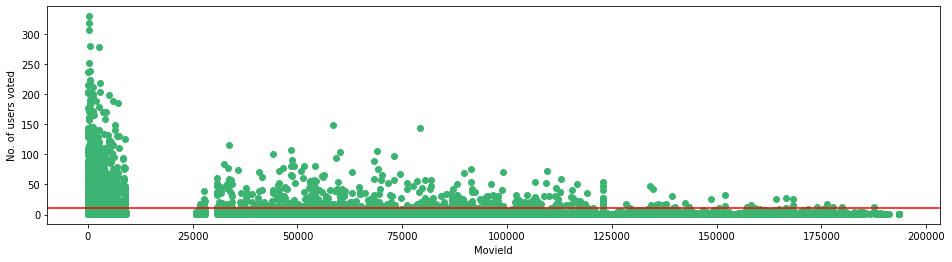

In [6]:
# Aggregating the number of users who voted and the number of movies that were voted.
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

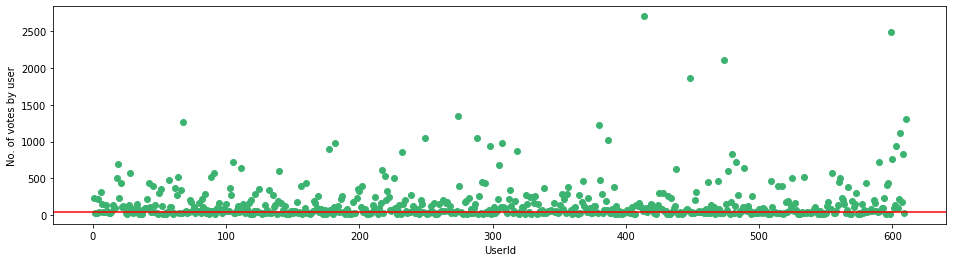

In [7]:
# Making the necessary modifications as per the threshold set.
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]

f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [8]:
# final dataset
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Removing sparsity
Our final_dataset has dimensions of 2121 * 378 where most of the values are sparse. We are using only a small dataset but for the original large dataset of movie lens which has more than 100000 features, our system may run out of computational resources when that is feed to the model. To reduce the sparsity we use the csr_matrix function from the scipy library.

In [9]:
csr_data = csr_matrix(final_dataset.values)
#print(csr_data)
final_dataset.reset_index(inplace=True)
#print(final_dataset)

### Making the movie recommendation system model
We will be using the KNN algorithm to compute similarity with cosine distance metric which is very fast and more preferable than pearson coefficient.

In [10]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [11]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(csr_data.toarray(), final_dataset['movieId'])

import numpy as np
from sklearn.neighbors import KDTree
kdt = KDTree(csr_data.toarray(), leaf_size=20, metric='euclidean')

#### Making the recommendation function
The working principle is very simple. We first check if the movie name input is in the database and if it is we use our recommendation system to find similar movies and sort them based on their similarity distance and output only the top 10 movies with their distances from the input movie.

In [12]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[1:]
        recommend_frame = []
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    else:
        return "No movies found. Please check your input"

In [84]:
def get_movie_kdtree(movie_name):
    movie_list = movies[movies['title'].str.contains(movie_name)]
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        cosine_sim = kdt.query(csr_data[movie_idx].toarray(), k=11, return_distance=True)
        dist = [(cosine_sim[1][-1][x], cosine_sim[0][-1][x]) for x in range(len(cosine_sim[0][0]))]
        recommend_frame = []
        for val in dist[1:]:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,11))
        return df
    return "No movies found. Please check your input"

In [85]:
def get_movie_naiveGaussian(movie_name):
    movie_list = movies[movies['title'].str.contains(movie_name)]
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        prediction = gnb.predict_log_proba(csr_data[movie_idx].toarray())
        distances = [(x, prediction[0][x]) for x in range(len(prediction[0]))]
        rec_movie_indices = sorted(distances ,key=lambda x: x[1])[::-1]
        recommend_frame = []
        for val in rec_movie_indices[1:11]:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,11))
        return df
    return "No movies found. Please check your input"

## Finally, We can recommend some movies

In [88]:
print("KNN")
print(get_movie_recommendation('Iron Man'))
print(get_movie_recommendation('Memento'))

KNN
                             Title  Distance
1             Avengers, The (2012)  0.285319
2          Dark Knight, The (2008)  0.285835
3                    WALL·E (2008)  0.298138
4                Iron Man 2 (2010)  0.307492
5                    Avatar (2009)  0.310893
6             Batman Begins (2005)  0.362759
7                 Star Trek (2009)  0.366029
8                  Watchmen (2009)  0.368558
9   Guardians of the Galaxy (2014)  0.368758
10                       Up (2009)  0.368857
                                                Title  Distance
1                                   Fight Club (1999)  0.272380
2   Lord of the Rings: The Fellowship of the Ring,...  0.316777
3                                  Matrix, The (1999)  0.326215
4        Eternal Sunshine of the Spotless Mind (2004)  0.346196
5       Lord of the Rings: The Two Towers, The (2002)  0.348358
6                            Kill Bill: Vol. 1 (2003)  0.350167
7   Lord of the Rings: The Return of the King, The...

In [86]:
print("KDTree")
print(get_movie_kdtree('Iron Man'))
print(get_movie_kdtree('Memento'))

KDTree
                                              Title   Distance
1                                 Iron Man 2 (2010)  25.238859
2                              Avengers, The (2012)  25.278449
3                                     Avatar (2009)  27.262612
4                                   Watchmen (2009)  27.408940
5                              Kung Fu Panda (2008)  27.418060
6                                  Star Trek (2009)  27.748874
7                                       Thor (2011)  27.852289
8                         X-Men: First Class (2011)  27.950850
9                    Guardians of the Galaxy (2014)  28.106939
10  Pirates of the Caribbean: At World's End (2007)  28.142495
                                                Title   Distance
1                            Kill Bill: Vol. 1 (2003)  40.062451
2        Eternal Sunshine of the Spotless Mind (2004)  40.062451
3                                   Fight Club (1999)  40.945085
4                            Kill Bill: 

In [87]:
print("Naive Bayes")
print(get_movie_naiveGaussian('Iron Man'))
print(get_movie_naiveGaussian('Memento'))

Naive Bayes
                                              Title      Distance
1                                 Iron Man 2 (2010) -8.242278e+10
2                              Avengers, The (2012) -8.268156e+10
3                                     Avatar (2009) -9.617069e+10
4                                   Watchmen (2009) -9.720583e+10
5                              Kung Fu Panda (2008) -9.727052e+10
6                                  Star Trek (2009) -9.963193e+10
7                                       Thor (2011) -1.003759e+11
8                         X-Men: First Class (2011) -1.010876e+11
9                    Guardians of the Galaxy (2014) -1.022198e+11
10  Pirates of the Caribbean: At World's End (2007) -1.024786e+11
                                                Title      Distance
1        Eternal Sunshine of the Spotless Mind (2004) -2.076743e+11
2                            Kill Bill: Vol. 1 (2003) -2.076743e+11
3                                   Fight Club (1999) -2.1